# CIFAR-10 Classifier

## 0. Computer vision libraries

In [1]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Other imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1534/1534), done.
remote: Compressing objects: 100% (135/135), done.
remote: Total 4393 (delta 1458), reused 1399 (delta 1399), pack-reused 2859 (from 2)
Receiving objects: 100% (4393/4393), 650.71 MiB | 16.81 MiB/s, done.
Resolving deltas: 100% (2660/2660), done.
Updating files: 100% (248/248), done.


In [2]:
# Set up device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Getting a dataset

The dataset we are going to use for this project is CIFAR-10.

More information about this dataset can be found here:
* PyTorch documentation: https://docs.pytorch.org/vision/0.21/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10

* Website dataset documentation: https://www.cs.toronto.edu/~kriz/cifar.html

This dataset consists of 60000 32x32 colour images in 10 classes, with 6000 per class. There are 50000 training images and 10000 test images.


In [ ]:
# Setup training and testing data
from torchvision.transforms import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.CIFAR10(root="data",
                              train = True,
                              download= True,
                              transform= transform)

test_data = datasets.CIFAR10(root="data",
                             train= False,
                             transform= transform)



100%|██████████| 170M/170M [00:03<00:00, 49.2MB/s]


In [ ]:
# See first training sample
image, label = train_data[0]
image, label

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
          [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
          [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
          ...,
          [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
          [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
          [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],
 
         [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
          [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
          [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
          ...,
          [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
          [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
          [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],
 
         [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
          [-0.8431, -1.0000,

In [ ]:
# What's the shape of our images?
print(f"Image size: {image.shape} -> [color_channels, heigh, width]")

Image size: torch.Size([3, 32, 32]) -> [color_channels, heigh, width]


In [ ]:
# How many examples do we have?
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(50000, 50000, 10000, 10000)

In [ ]:
# See class names
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### 1.1 Visualizing our data

Image shape: torch.Size([3, 32, 32])


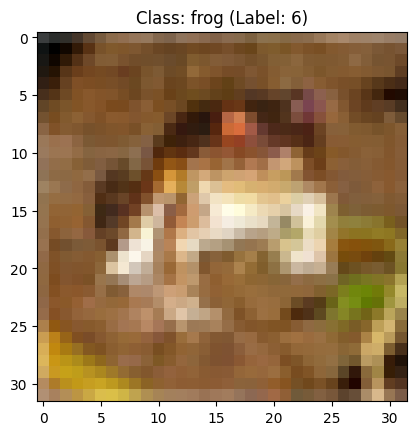

In [ ]:
import matplotlib.pyplot as plt
image, label = train_data[0]
image = image / 2 + 0.5 # unnormalize image for better visualization
print(f"Image shape: {image.shape}")
plt.imshow(image.permute(1,2,0)) # permute because our image is in CHW and imshow needs HCW
plt.title(f"Class: {class_names[label]} (Label: {label})");

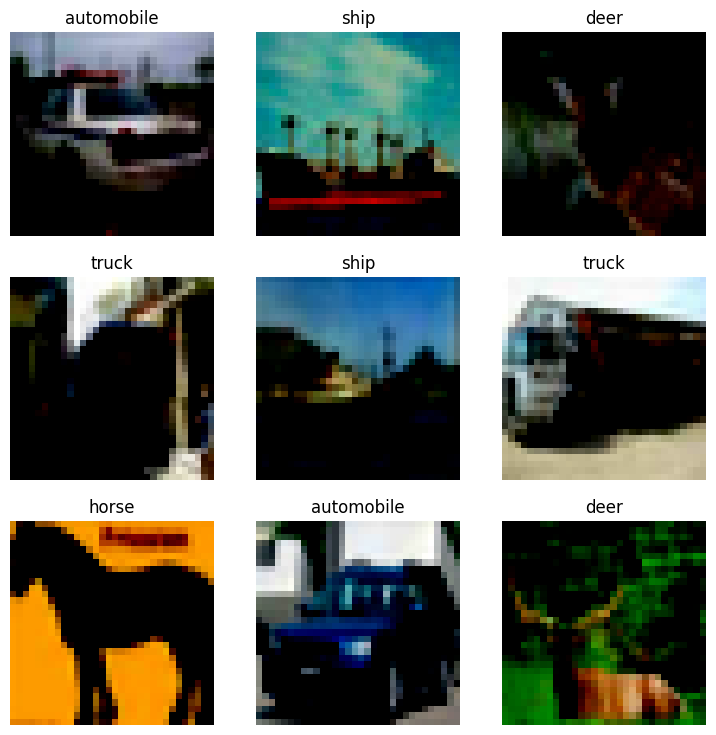

In [ ]:
# Plot more images
fig = plt.figure(figsize=(9,9))
rows, cols = 3, 3
for i in range(1, rows * cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1,2,0))
  plt.title(class_names[label])
  plt.axis(False);

## 2. Prepare DataLoader

In [ ]:
from torch.utils.data import DataLoader

# Setup batch size
BATCH_SIZE = 4

# Turn dataset into iterables
train_dataloader = DataLoader(train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

# Print some info
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 12500 batches of 4
Length of test dataloader: 2500 batches of 4


## Model 0: Baseline model

In [ ]:
# Create a convolutional neural network
class CIFAR10V0(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units *8 *8,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.block_2(self.block_1(x)))


In [ ]:
# Setup model with the right parameters:
model_0 = CIFAR10V0(input_shape=3, # number of color channels
                    hidden_units = 10,
                    output_shape = len(class_names)).to(device)
model_0

CIFAR10V0(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=640, out_features=10, bias=True)
  )
)

### 3.1 Make predictions

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Caculate results from the model
from going_modular.going_modular import engine
set_seeds()

model_0_results = engine.train(model=model_0,
                               train_dataloader = train_dataloader,
                               test_dataloader = test_dataloader,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               epochs = 5,
                               device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4661 | train_acc: 0.4726 | test_loss: 1.2670 | test_acc: 0.5562
Epoch: 2 | train_loss: 1.1882 | train_acc: 0.5806 | test_loss: 1.1181 | test_acc: 0.5967
Epoch: 3 | train_loss: 1.0929 | train_acc: 0.6144 | test_loss: 1.0784 | test_acc: 0.6193
Epoch: 4 | train_loss: 1.0464 | train_acc: 0.6321 | test_loss: 1.0626 | test_acc: 0.6263
Epoch: 5 | train_loss: 1.0150 | train_acc: 0.6407 | test_loss: 1.0545 | test_acc: 0.6296


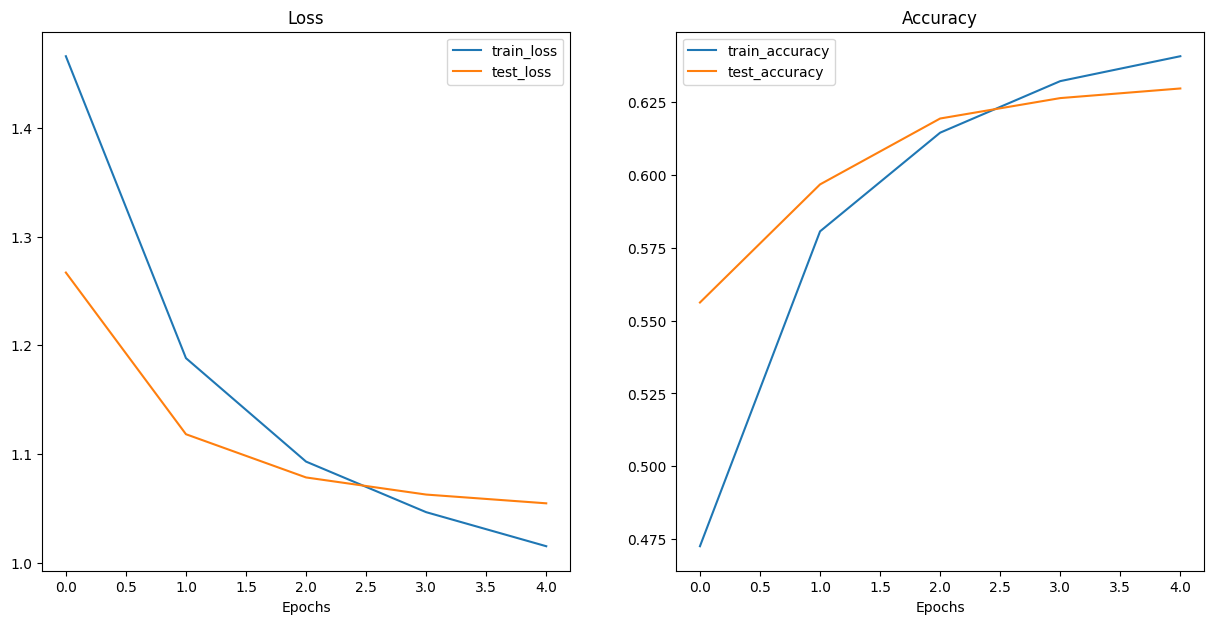

In [ ]:
# Plot loss curves
plot_loss_curves(model_0_results)

## 4. Trying to improve our model

In [ ]:
# Create a convolutional neural network
class CIFAR10V1(nn.Module):
    """
    Model architecture copying TinyVGG from
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2), # default stride value is same as kernel_size
            nn.Dropout(p=0.25)
            )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features = hidden_units*8*8,
                      out_features = 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.block_2(self.block_1(x)))



In [ ]:
model_1 = CIFAR10V1(input_shape= 3,
                    hidden_units = 128,
                    output_shape = len(class_names)).to(device)
model_1

CIFAR10V1(
  (block_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (block_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Caculate results from the model
from going_modular.going_modular import engine
set_seeds()

model_1_results = engine.train(model=model_1,
                               train_dataloader = train_dataloader,
                               test_dataloader = test_dataloader,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               epochs = 5,
                               device = device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9867 | train_acc: 0.2215 | test_loss: 1.6994 | test_acc: 0.3382
Epoch: 2 | train_loss: 1.8153 | train_acc: 0.2698 | test_loss: 1.6046 | test_acc: 0.3380
Epoch: 3 | train_loss: 1.6867 | train_acc: 0.3199 | test_loss: 1.4619 | test_acc: 0.4179
Epoch: 4 | train_loss: 1.5082 | train_acc: 0.4238 | test_loss: 1.1704 | test_acc: 0.6017
Epoch: 5 | train_loss: 1.3477 | train_acc: 0.5047 | test_loss: 1.0312 | test_acc: 0.6575


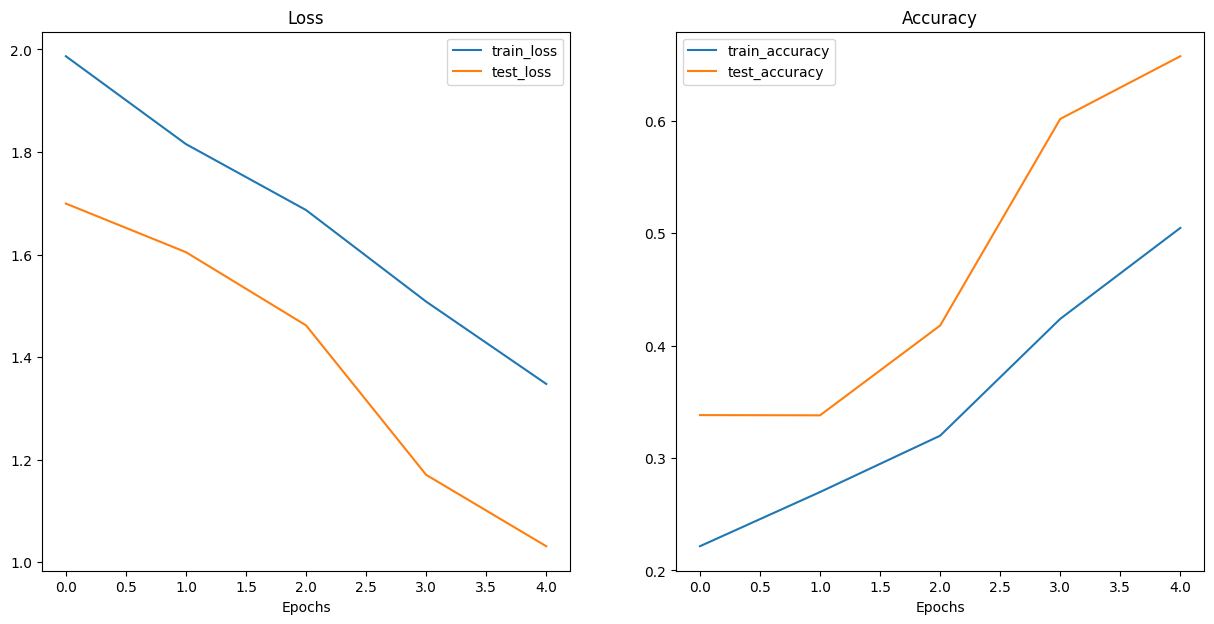

In [ ]:
# Plot loss curves
plot_loss_curves(model_1_results)

## 4. Model with Data Augmentation

In [ ]:
# Create training and testing transformms
import torchvision.transforms as transforms

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),  # Mean for RGB
                         (0.5, 0.5, 0.5))  # Std for RGB
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])


In [ ]:
# Create train and test data with new transforms
train_data_aug = datasets.CIFAR10(root="data",
                                  train = True,
                                  download = True,
                                  transform = train_transforms)

test_data = datasets.CIFAR10(root="data",
                            train= False,
                            download = True,
                            transform = test_transforms)

In [ ]:
# Create datasets

# Setup batch size
BATCH_SIZE = 32

# Turn dataset into iterables
train_dataloader = DataLoader(train_data_aug,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

In [ ]:
# Create a convolutional neural network
class CIFAR10V2(nn.Module):
    """
    Model architecture copying TinyVGG from
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2),
            nn.Dropout(p=0.25)
            )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.25)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features = hidden_units*8*8,
                      out_features = 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.block_2(self.block_1(x)))



In [ ]:
# Setup model with the right parameters:
model_2 = CIFAR10V2(input_shape=3, # number of color channels
                    hidden_units = 128,
                    output_shape = len(class_names)).to(device)
model_2

CIFAR10V2(
  (block_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (block_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)

# Caculate results from the model
from going_modular.going_modular import engine
set_seeds()

model_2_results = engine.train(model=model_2,
                               train_dataloader = train_dataloader,
                               test_dataloader = test_dataloader,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               epochs = 10,
                               device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7442 | train_acc: 0.3373 | test_loss: 1.2867 | test_acc: 0.5288
Epoch: 2 | train_loss: 1.4363 | train_acc: 0.4674 | test_loss: 1.0862 | test_acc: 0.6252
Epoch: 3 | train_loss: 1.2985 | train_acc: 0.5234 | test_loss: 0.9308 | test_acc: 0.6732
Epoch: 4 | train_loss: 1.2107 | train_acc: 0.5559 | test_loss: 0.8581 | test_acc: 0.7038
Epoch: 5 | train_loss: 1.1492 | train_acc: 0.5826 | test_loss: 0.7940 | test_acc: 0.7235
Epoch: 6 | train_loss: 1.0962 | train_acc: 0.5997 | test_loss: 0.7582 | test_acc: 0.7327
Epoch: 7 | train_loss: 1.0535 | train_acc: 0.6192 | test_loss: 0.7889 | test_acc: 0.7276
Epoch: 8 | train_loss: 1.0196 | train_acc: 0.6314 | test_loss: 0.7373 | test_acc: 0.7499
Epoch: 9 | train_loss: 0.9731 | train_acc: 0.6494 | test_loss: 0.6762 | test_acc: 0.7687
Epoch: 10 | train_loss: 0.9160 | train_acc: 0.6718 | test_loss: 0.6731 | test_acc: 0.7747


## 5. Model with transfer learning

In [4]:
from torchvision import transforms

# Get pretrained weights and transforms
weights = torchvision.models.ResNet18_Weights.DEFAULT

transform_resnet = torchvision.transforms.Compose([
    weights.transforms()
])


In [5]:
# Load the data with the correspondent transforms
train_data_restnet = datasets.CIFAR10(root = "data",
                                      train = True,
                                      download = True,
                                      transform = transform_resnet)
test_data_resnet = datasets.CIFAR10(root = "data",
                                    train = False,
                                    download = True,
                                    transform = transform_resnet)

100%|██████████| 170M/170M [00:13<00:00, 12.6MB/s]


In [7]:
# Create dataloaders
from torch.utils.data import DataLoader
BATCH_SIZE = 32

train_dataloader_resnet = DataLoader(train_data_restnet,
                                     batch_size = BATCH_SIZE,
                                     shuffle = True)

test_dataloader_resnet = DataLoader(test_data_resnet,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False)

In [9]:
# Get class names
class_names = train_data_restnet.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [16]:
# Load the model
resnet_model = torchvision.models.resnet18(weights=weights)
resnet_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
# Freeze all layers initially
for param in resnet_model.parameters():
  param.requires_grad = False

# Replace the classifier
resnet_model.fc = nn.Linear(in_features= 512, out_features= len(class_names))


# Unfrezze the last block and the classifier
for param in resnet_model.layer4.parameters():
    param.requires_grad = True

for param in resnet_model.fc.parameters():
    param.requires_grad = True


resnet_model = resnet_model.to(device)

In [18]:
# Train the model and get results
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=0.001)

set_seeds()
results_resnet_model = engine.train(model = resnet_model,
                                    train_dataloader = train_dataloader_resnet,
                                    test_dataloader = test_dataloader_resnet,
                                    optimizer = optimizer,
                                    loss_fn = loss_fn,
                                    epochs = 10,
                                    device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5421 | train_acc: 0.8152 | test_loss: 0.4114 | test_acc: 0.8604
Epoch: 2 | train_loss: 0.2954 | train_acc: 0.8991 | test_loss: 0.3411 | test_acc: 0.8847
Epoch: 3 | train_loss: 0.1852 | train_acc: 0.9356 | test_loss: 0.3625 | test_acc: 0.8886
Epoch: 4 | train_loss: 0.1230 | train_acc: 0.9575 | test_loss: 0.3855 | test_acc: 0.8926
Epoch: 5 | train_loss: 0.0883 | train_acc: 0.9700 | test_loss: 0.4205 | test_acc: 0.8898
Epoch: 6 | train_loss: 0.0697 | train_acc: 0.9770 | test_loss: 0.4087 | test_acc: 0.8961
Epoch: 7 | train_loss: 0.0614 | train_acc: 0.9794 | test_loss: 0.4682 | test_acc: 0.8914
Epoch: 8 | train_loss: 0.0559 | train_acc: 0.9811 | test_loss: 0.4523 | test_acc: 0.8955
Epoch: 9 | train_loss: 0.0462 | train_acc: 0.9846 | test_loss: 0.5388 | test_acc: 0.8852
Epoch: 10 | train_loss: 0.0415 | train_acc: 0.9863 | test_loss: 0.4541 | test_acc: 0.8998


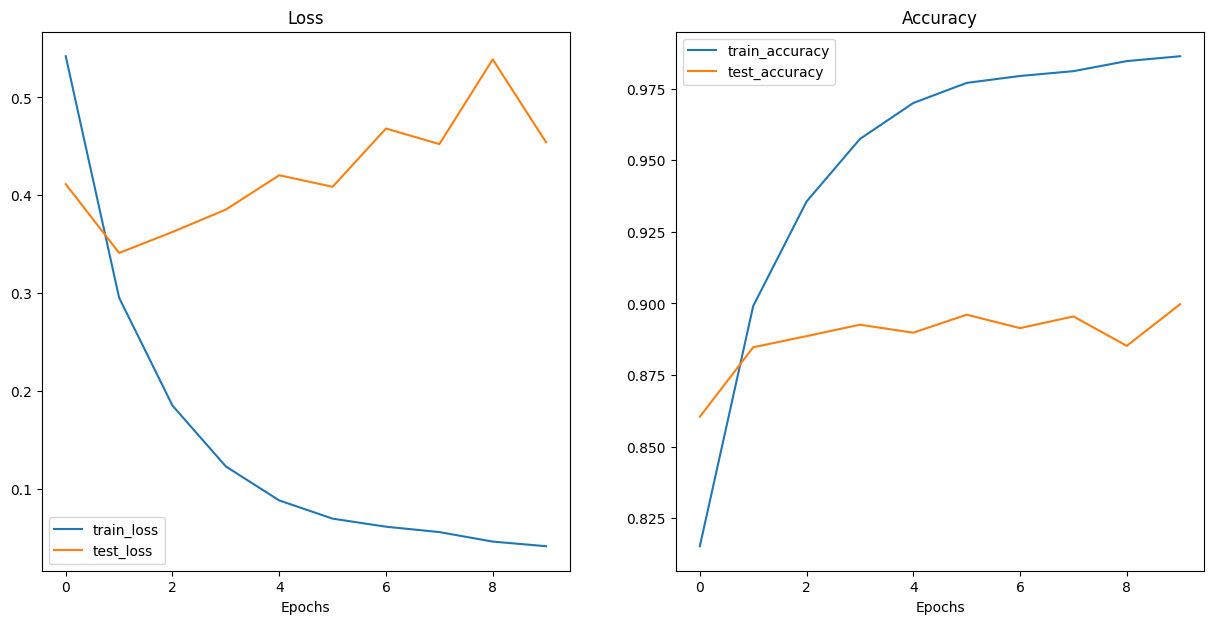

In [19]:
from helper_functions import plot_loss_curves
plot_loss_curves(results = results_resnet_model)

In [21]:
from going_modular.going_modular import utils

# Create a model path
resnet_model_path = "pretrained_resnet18_feature_extractor_cifar_10.pth"

# Save FoodVision Big model
utils.save_model(model=resnet_model,
                 target_dir="models",
                 model_name=resnet_model_path)

[INFO] Saving model to: models/pretrained_resnet18_feature_extractor_cifar_10.pth


## Deploy the Model with our best Model results

In [20]:
def create_resnet18_model(num_classes: int = 10,
                          seed: int = 42):
  """ Creates a ResNet18 feature extractor model and transform frezzing all the layers
  and later unfreezing part of them.

  Arg:
    num_classes (int, optional): number of classes in the classifier head.
      Defaults to 10.
    seed(int, optional): random seed value. Defaults to 42.

  Returns:
    model(torch.nn.Module): ResNet18 feature extraactor model
    transforms (torchvision.transforms): ResNet18 image transforms.
  """
  # Create ResNet18 pretrained weights, transform and model
  weights = torchvision.models.ResNet18_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.resnet18(weights=weights)

  # Freeze all layers in the base model
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head with random seed for reproducibility
  resnet_model.fc = nn.Linear(in_features= 512, out_features= len(class_names))

  # Unfrezze the last block and the classifier
  for param in resnet_model.layer4.parameters():
    param.requires_grad = True

  for param in resnet_model.fc.parameters():
    param.requires_grad = True

  return model, transforms


In [23]:
from pathlib import Path

# Create CIFAR-10 path
cifar10_path = Path("demos/cifar10/")

# Make CIFAR-10 directory
cifar10_path.mkdir(parents = True, exist_ok = True)

# Make CIFAR-10 demo examples directory
(cifar10_path / "exmaples").mkdir(parents = True, exist_ok = True)